In [160]:
# imports
from utils.pointcloud import BBox, grid_subsample_simple
from data.fwf_dataset import FwfDataset
from models.fgf import FGFeatNetwork
from omegaconf import OmegaConf
import tracemalloc

# tracemalloc.start()


import numpy as np
import json
import os


# build config
cfg = OmegaConf.load("./config/default.yaml")
cfg = OmegaConf.merge(cfg, OmegaConf.load(cfg.data.split))
with open(os.path.join(cfg.data.dataset_root, 'class_dict.json'),'r') as f:
    cfg = OmegaConf.merge(cfg, OmegaConf.create({'data':{'label_schema':json.load(f)}}))


print(OmegaConf.to_yaml(cfg))






general:
  device: cuda
  batch_size: 1024
  weight_decay: 0.0005
  max_epochs: 50
data:
  dataset_root: ../../02_Datasets/FWF_Subsampled/0.01/
  split: ./config/default_split.yaml
  preprocessing:
    _transformsTraining_:
      xyz:
        TransCenterXyz: {}
    _transformsValidation_:
      xyz:
        TransCenterXyz: {}
  scalar_input_fields:
  - xyz
  - rgb
  - riegl_feats
  - normals
  - incAngles
  - distanceFromScanner
  fw_input_field: true
  label_names:
  - labels_3
  query_grid_size: 0.15
  subsample_on_gpu: true
  num_neib_normalsComputation: 20
  num_neib_featureExtraction: 128
  _trainProjects_:
  - proj_name: 2024-03-22_FW_Koenigshuegel.FwfProj
  - proj_name: 2024-04-05_FW_Westbahnhof_02.FwfProj
  - proj_name: 2024-04-05_FW_Westbahnhof_03.FwfProj
  - proj_name: 2024-04-05_FW_Westbahnhof_04.FwfProj
  - proj_name: 2024-04-05_FW_Westbahnhof_05.FwfProj
  - proj_name: 2024-05-10_FW_RWTH_Zentrum_01.FwfProj
  - proj_name: 2024-07-31_FW_Bruecke_Koenigstr.FwfProj
    bboxes:
 

In [161]:
train_ds = FwfDataset(cfg, cfg.data.preprocessing._transformsTraining_, cfg.data._trainProjects_)
val_ds = FwfDataset(cfg, cfg.data.preprocessing._transformsValidation_, cfg.data._valProjects_)


Loading '2024-03-22_FW_Koenigshuegel.FwfProj'; Bounding box IDs = default
Loading '2024-04-05_FW_Westbahnhof_02.FwfProj'; Bounding box IDs = default
Loading '2024-04-05_FW_Westbahnhof_03.FwfProj'; Bounding box IDs = default
Loading '2024-04-05_FW_Westbahnhof_04.FwfProj'; Bounding box IDs = default
Loading '2024-04-05_FW_Westbahnhof_05.FwfProj'; Bounding box IDs = default
Loading '2024-05-10_FW_RWTH_Zentrum_01.FwfProj'; Bounding box IDs = default
Loading '2024-07-31_FW_Bruecke_Koenigstr.FwfProj'; Bounding box IDs = [0, 2]
Loading '2024-08-02_FW_Bruecke_A44_VerlautenheidenerStr.FwfProj'; Bounding box IDs = default
Loading '2024-08-02_FW_Bruecke_Deltourserb.FwfProj'; Bounding box IDs = default
Loading '2024-08-02_FW_Bruecke_Kasinostrasse.FwfProj'; Bounding box IDs = [1]
Loading '2024-08-02_FW_Bruecke_RotheErde.FwfProj'; Bounding box IDs = default
Loading '2024-08-02_FW_Bruecke_Rottstrasse.FwfProj'; Bounding box IDs = default
Loading '2023-08-28_FW_EingangBauing.FwfProj'; Bounding box IDs 

In [162]:
# normals, inc angles
train_ds.subsample_grid(cfg.data.query_grid_size, save_inv=True)
train_ds.compute_neibors_knn(k=cfg.data.num_neib_normalsComputation)
train_ds.compute_normals_knn()
train_ds.compute_incAngles()


val_ds.subsample_grid(cfg.data.query_grid_size, save_inv=True)
val_ds.compute_neibors_knn(k=cfg.data.num_neib_normalsComputation)
val_ds.compute_normals_knn()
val_ds.compute_incAngles()


Computing neibors for '2024-03-22_FW_Koenigshuegel.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-04-05_FW_Westbahnhof_02.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-04-05_FW_Westbahnhof_03.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-04-05_FW_Westbahnhof_04.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-04-05_FW_Westbahnhof_05.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-05-10_FW_RWTH_Zentrum_01.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-07-31_FW_Bruecke_Koenigstr.FwfProj::bboxId=000' @ k=20
Computing neibors for '2024-07-31_FW_Bruecke_Koenigstr.FwfProj::bboxId=002' @ k=20
Computing neibors for '2024-08-02_FW_Bruecke_A44_VerlautenheidenerStr.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-08-02_FW_Bruecke_Deltourserb.FwfProj::defaultBbox' @ k=20
Computing neibors for '2024-08-02_FW_Bruecke_Kasinostrasse.FwfProj::bboxId=001' @ k=20
Computing neibors for '2024-08-02_FW_Bruecke_RotheErde.FwfProj::defaultBbox'

In [163]:
from torch.utils.data import DataLoader

# create model
model = FGFeatNetwork(cfg=cfg,
    num_input_feats = train_ds[0]['features_neibors'].shape[-1],
    ).to(device=cfg.general.device)


In [5]:
# train_dl = DataLoader(train_ds, batch_size=cfg.general.batch_size, num_workers=0) --> ca. 6it/sec, no mem problem
# train_dl = DataLoader(train_ds, batch_size=cfg.general.batch_size, num_workers=2) --> ca. 12 it/sec, doable but still knapp

In [164]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch
from tqdm import tqdm
from utils.metrics import get_multilevel_metrics, print_metrics, combine_metrics_list
from time import time



criterion = CrossEntropyLoss()

optim = Adam(params=model.parameters(), weight_decay=cfg.general.weight_decay)

val_dl = DataLoader(val_ds, batch_size=cfg.general.batch_size, num_workers=4, multiprocessing_context='fork')

for epoch in range(cfg.general.max_epochs):
    print(f"Epoch-{epoch:03}")

    start = time()
    print(f'Sampling training dataset.',end=' ')
    train_ds.subsample_random(0.01)
    train_ds.compute_neibors_knn(k=cfg.data.num_neib_featureExtraction, verbose=False)
    train_dl = DataLoader(train_ds, batch_size=cfg.general.batch_size, num_workers=4, pin_memory=True, multiprocessing_context='fork')
    print(f'Done. Took {time()-start:.2f}.')
    # train
    epoch_train_loss = []
    epoch_metrics = []
    model.train()
    for i, batch in enumerate(tqdm(train_dl, desc=f"{'Training':<15}", leave=True)):
        optim.zero_grad()
        # put batch on device
        for k, v in batch.items():
            batch[k] = v.to(device=cfg.general.device)

        # forward pass
        out = model(batch)
        raise Exception
        # agregate loss on all levels
        loss = torch.tensor(0.).to(device=cfg.general.device)
        for k in out.keys():
            output = out[k]
            gt = batch[k] # type:ignore
            loss += criterion(output, gt)
        
        loss.backward()
        optim.step()


        # aggregate values for metric calculation
        epoch_train_loss.append(loss.item())


        preds = {k:torch.argmax(v,dim=1) for k,v in out.items()}    
        epoch_metrics.append(get_multilevel_metrics(preds, batch, cfg))
        del batch, out
        torch.cuda.empty_cache()
        



    epoch_metrics = combine_metrics_list(epoch_metrics,cfg)
    print_metrics(epoch_metrics, cfg)
    print(f"L_train:{np.mean(epoch_train_loss):.4f} ")
    
    # validate  
    epoch_metrics = []
    epoch_val_loss = []
    model.eval()
    with torch.no_grad():
        for i,batch in enumerate(tqdm(val_dl, desc=f"{'Validation':<15}", leave=True)):
            # put batch on device
            for k, v in batch.items():
                batch[k] = v.to(device=cfg.general.device)

            # forward pass
            out = model(batch)
            
            # agregate loss on all levels
            loss = torch.tensor(0.).to(device=cfg.general.device)
            for k in out.keys():
                output = out[k]
                gt = batch[k] # type:ignore
                loss += criterion(output, gt)

        # aggregate values for metric calculation
        epoch_val_loss.append(loss.item())
        preds = {k:torch.argmax(v,dim=1) for k,v in out.items()}    
        epoch_metrics.append(get_multilevel_metrics(preds, batch, cfg))
        del batch, out
        torch.cuda.empty_cache()
            
    epoch_metrics = combine_metrics_list(epoch_metrics,cfg)
    print_metrics(epoch_metrics, cfg)


    print(f"L_val:{np.mean(epoch_val_loss):.4f}")
    print('\n')

    

Epoch-000
Sampling training dataset. Done. Took 13.97.


Training       :   0%|          | 0/885 [00:01<?, ?it/s]


Exception: 

In [114]:
self = train_ds
index = 56

proj_idx = np.argwhere(index<self.proj_lens_cumsum)[0][0]
size_prev = self.proj_lens_cumsum[proj_idx-1] if proj_idx > 0 else 0
residual_idx = index - size_prev
neibs = self.projects[proj_idx]['neibors'][residual_idx]

return_dict = dict(
    features_neibors = np.concatenate(
        [
            self.transforms_dict[f](self.projects[proj_idx][f][neibs])
            if f in self.transforms_dict else self.projects[proj_idx][f][neibs]
            for f in self.cfg.data.scalar_input_fields
        ],
        axis=-1
    ).astype(np.float32),
    features_point = np.concatenate(
        [
            self.transforms_dict[f](self.projects[proj_idx][f][residual_idx][None,:])
            if f in self.transforms_dict else self.projects[proj_idx][f][residual_idx][None,:]
            for f in self.cfg.data.scalar_input_fields
        ],
        axis=-1
    ).astype(np.float32)
)

# add waveforms
return_dict.update(dict(
    wfm_neibors = self.projects[proj_idx]['wfm'][neibs] if self.cfg.data.fw_input_field else None,
    wfm_point = self.projects[proj_idx]['wfm'][residual_idx][None,:] if self.cfg.data.fw_input_field else None,
)) # type:ignore

# add labels as separate entries
for label_i, label_name in enumerate(self.label_names):
    return_dict.update({
        label_name : self.projects[proj_idx]['labels_sub'][residual_idx][label_i]
    })

In [142]:
batch['wfm_neibors']

{'labels_0': {'scanArtefact': 0, 'manMade': 1, 'natural': 2}, 'labels_1': {'unspecified': 0, 'building': 1, 'sealedSurface': 2, 'streetFurniture': 3, 'vegetation': 4, 'vehicle': 5, 'naturalGround': 6, 'movingObject': 7}, 'labels_2': {'unspecified': 0, 'electricalAppliance': 1, 'facadeSurface': 2, 'pipeLike': 3, 'frameElement': 4, 'sign': 5, 'kerbStone': 6, 'nonTiledPaving': 7, 'shaft': 8, 'stair': 9, 'tiledPaving': 10, 'fence': 11, 'trashCan': 12, 'vegetation': 13, 'bicycle': 14, 'car': 15, 'scooter': 16, 'naturalGround': 17}, 'labels_3': {'unspecified': 0, 'metal': 1, 'naturalStone': 2, 'brick': 3, 'brick(graffiti)': 4, 'concrete': 5, 'concrete(rough)': 6, 'concrete(graffiti)': 7, 'marking': 8, 'mesh': 9, 'plastic': 10, 'poster': 11, 'leaves': 12, 'asphalt': 13, 'cable': 14, 'grass': 15, 'soil': 16, 'treeTrunk': 17}}

In [168]:
batch['wfm_neibors'][189]

tensor([[-0.3505, -0.3457, -0.3409,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3457, -0.3441,  0.2514,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3425, -0.3184,  0.6752,  ..., -0.5752, -0.5752, -0.5752],
        ...,
        [-0.3505, -0.3553, -0.3425,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3473, -0.3457, -0.2767,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3360, -0.3473, -0.3521,  ..., -0.5752, -0.5752, -0.5752]],
       device='cuda:0')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

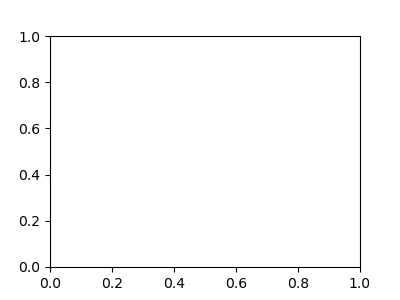

In [147]:
fig, ax = plt.subplots(1,1, figsize=(4,3))
# for wfm in self.projects[proj_idx]['wfm'][neibs]:
for wfm in batch['wfm_neibors']:
    ax.plot(range(len(wfm)),wfm)

In [117]:
return_dict['wfm_neibors']

array([[-0.34727842, -0.356909  , -0.35369882, ..., -0.57520264,
        -0.57520264, -0.57520264],
       [-0.36011922, -0.3633294 , -0.2750489 , ..., -0.57520264,
        -0.57520264, -0.57520264],
       [-0.3488835 , -0.3488835 , -0.34567332, ..., -0.57520264,
        -0.57520264, -0.57520264],
       ...,
       [-0.34727842, -0.3520937 , -0.35369882, ..., -0.57520264,
        -0.57520264, -0.57520264],
       [-0.3440682 , -0.340858  , -0.33283252, ..., -0.57520264,
        -0.57520264, -0.57520264],
       [-0.34727842, -0.3504886 ,  0.20006073, ..., -0.57520264,
        -0.57520264, -0.57520264]], dtype=float32)

In [29]:

train_ds.projects[0]['rgb'].max()

3.8171392670390047

In [25]:
np.set_printoptions(suppress=True)
batch['features_neibors'][bn,0,:].detach().cpu().numpy()


array([ 0.00159329, -0.00437775,  0.00521958,  2.40417   ,  0.        ,
        0.        ,  1.2304521 ,  1.3386139 , -0.01447706,  0.        ,
       -0.16054411, -0.87490314, -0.40461874,  0.02259678,  1.1323776 ,
        8.68487   ], dtype=float32)

In [28]:
xyz.mean()

-1.2417635e-09

In [42]:
visualize_point_cloud=None

In [45]:
def visualize_point_cloud(point_cloud, rgb=None, scalar_field=None, cmap='viridis', point_size=1):
    """
    Visualize a 3D point cloud with optional RGB colors or scalar field coloring.

    Parameters:
        point_cloud (numpy.ndarray): Nx3 array with XYZ coordinates.
        rgb (numpy.ndarray, optional): Nx3 array with RGB values (0-1 range).
        scalar_field (numpy.ndarray, optional): Nx1 array with scalar values for coloring.
        cmap (str, optional): Matplotlib colormap name to use for scalar field coloring.
    """
    if point_cloud.shape[1] != 3:
        raise ValueError("Point cloud must be a Nx3 array.")

    if rgb is not None and (rgb.shape[0] != point_cloud.shape[0] or rgb.shape[1] != 3):
        raise ValueError("RGB array must have the same number of points as the point cloud and be Nx3.")

    if scalar_field is not None and scalar_field.shape[0] != point_cloud.shape[0]:
        raise ValueError("Scalar field must have the same number of points as the point cloud.")

    # Extract XYZ coordinates
    x, y, z = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]

    # Calculate aspect ratio
    x_range = x.max() - x.min()
    y_range = y.max() - y.min()
    z_range = z.max() - z.min()
    max_range = max(x_range, y_range, z_range)

    # Set up the plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Configure aspect ratio to avoid skewing
    ax.set_box_aspect((x_range, y_range, z_range))

    # Coloring logic
    if rgb is not None:
        colors = rgb
    elif scalar_field is not None:
        colors = scalar_field.flatten()
    else:
        colors = 'b'  # Default to blue if no color data provided

    # Plot the point cloud
    scatter = ax.scatter(x, y, z, c=colors, cmap=cmap if scalar_field is not None else None, s=point_size)

    # Add a colorbar if using a scalar field
    if scalar_field is not None:
        cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
        cbar.set_label('Scalar Field')

    # Set labels and show
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

In [52]:
model(batch)

{'labels_3': tensor([[-0.2530, -0.0555, -1.2828,  ...,  0.1753, -0.3972, -0.7737],
         [-0.4082,  0.0858, -1.5055,  ..., -0.0983, -0.5441, -0.8176],
         [-0.3350,  0.3932, -0.8607,  ..., -0.9647, -0.8374, -1.0176],
         ...,
         [-0.4928, -0.2914, -1.4435,  ...,  0.6758, -0.6590, -1.2715],
         [-0.3256,  0.2544, -1.0028,  ..., -0.7379, -0.5194, -0.8150],
         [-0.3665,  0.1668, -0.8782,  ..., -0.5877, -0.4430, -0.3740]],
        device='cuda:0', grad_fn=<AddmmBackward0>)}

In [177]:
for wfmbatch['wfm_neibors'][2]

tensor([[-0.3360, -0.3409, -0.3409,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3296, -0.3200, -0.0391,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3441, -0.3393, -0.3120,  ..., -0.5752, -0.5752, -0.5752],
        ...,
        [-0.3473, -0.3521, -0.3441,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3393, -0.3457, -0.3489,  ..., -0.5752, -0.5752, -0.5752],
        [-0.3489, -0.3441, -0.3023,  ..., -0.5752, -0.5752, -0.5752]],
       device='cuda:0')

In [182]:
feats = batch['features_neibors'][bn].detach().cpu().numpy()
feats[0]

array([-3.3398438e-03,  1.4257808e-04,  3.6953124e-03, -6.3136649e-01,
       -9.8126328e-01, -3.6066738e-01,  1.1272665e+00, -1.3312368e+00,
       -2.7384259e-02,  0.0000000e+00, -1.6054411e-01,  3.5153383e-01,
       -9.3477899e-01,  5.1109198e-02,  2.1273794e+00,  3.6316441e+01],
      dtype=float32)

In [62]:
batch['features_point'][bn]

tensor([[ 0.0000,  0.0000,  0.0000, -1.3772, -1.4683, -0.8968, -0.0551,  0.3772,
         -0.0188,  0.0000, -0.1605,  0.2402,  0.1254, -0.9626,  2.4049,  3.3352]],
       device='cuda:0')

In [194]:
batch['features_point'].shape

torch.Size([1024, 1, 16])

In [202]:
from torch import nn
a = nn.Linear(16,64).to(device='cuda')
a(batch['features_point']).mean(dim=0)

tensor([[ 2.0721,  2.6202, -0.9236, -2.3281,  1.5159, -0.1514,  2.4839,  2.4306,
          1.8203,  0.1773,  1.4028, -1.8797,  2.6425,  2.7036,  1.2068, -0.1550,
         -2.2282, -2.2441,  1.1935,  0.7319,  0.2269,  0.8072,  2.0145,  0.0654,
         -0.8334, -1.8022,  0.3781, -0.7652,  0.6155, -0.2527, -2.2237, -0.2729,
         -2.1069,  2.1364,  2.3061,  2.9026,  1.0945, -0.6369,  0.9222, -0.3531,
         -2.5746,  1.2732, -2.0947,  2.3141, -1.2633,  2.3893,  2.2711,  2.5950,
          0.1884, -0.8331,  2.4880, -2.5397, -2.0679,  0.3399,  1.3890,  2.1123,
         -1.2516,  0.9078,  0.5183,  0.5150,  2.4044,  1.3403, -1.3142,  1.7310]],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [195]:
model.mlp1a

Sequential(
  (0): Linear(in_features=16, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=64, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.3, inplace=False)
)

In [192]:
model.mlp1(batch['features_point'])

tensor([[[0.0000, 0.6162, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.1124, 0.5594,  ..., 0.0000, 1.3264, 0.3837]],

        [[0.0000, 0.0000, 1.4438,  ..., 0.0000, 0.0000, 0.6422]],

        ...,

        [[0.0000, 0.0000, 0.6349,  ..., 0.0181, 0.0000, 0.3743]],

        [[0.0000, 0.0000, 0.0583,  ..., 0.0000, 0.5312, 0.0000]],

        [[0.0000, 0.0000, 0.2821,  ..., 0.0000, 0.0000, 0.4119]]],
       device='cuda:0', grad_fn=<NativeDropoutBackward0>)

('concrete', 5)


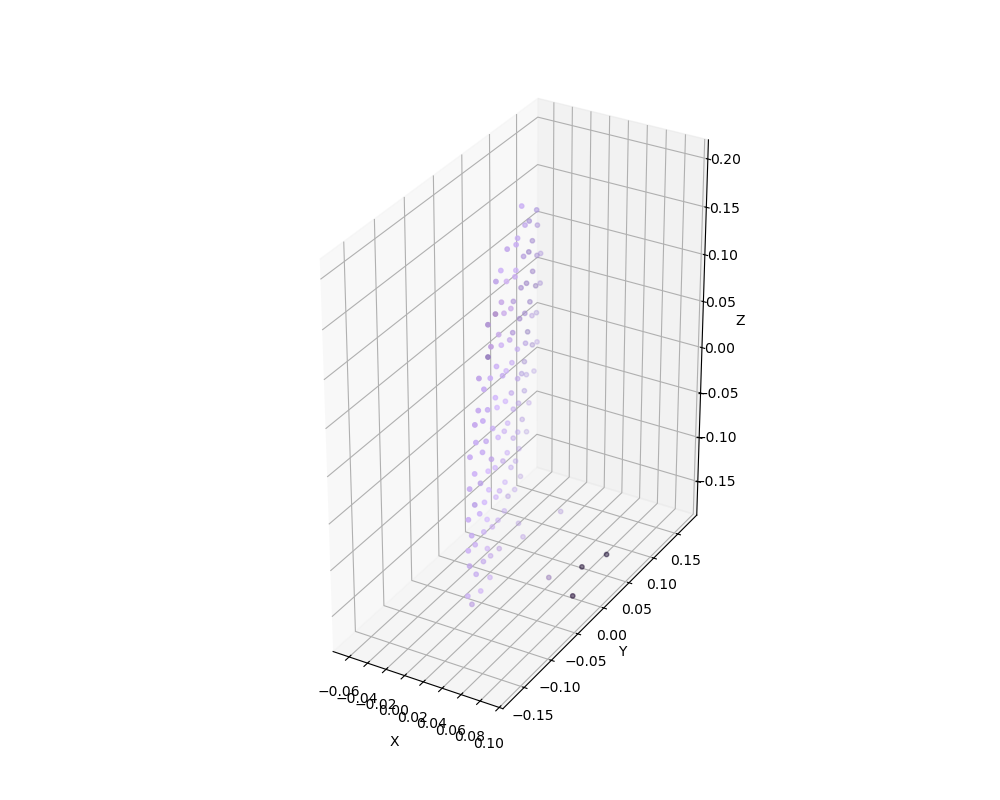

In [190]:
%matplotlib widget

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# from utils.visualization import visualize_point_cloud
from matplotlib import pyplot as plt
bn = 0
xyz = batch['features_neibors'][bn,:,:3].detach().cpu().numpy()
print(list(cfg.data.label_schema['labels_3'].items())[batch['labels_3'][bn].detach().cpu().numpy()])
rgb = batch['features_neibors'][bn,:,3:6].detach().cpu().numpy()
rgb -= rgb.min()
rgb /= rgb.max()
visualize_point_cloud(xyz, rgb=rgb,point_size=10)
# plt.show()


In [ ]:
# Epoch-049
# Sampling training dataset. Done. Took 22.75.
# Training       : 100%|██████████| 885/885 [07:28<00:00,  1.98it/s]
#                 oA      mIoU        mP        mR       mF1     mcAcc
# labels_0  0.965222  0.685658  0.766195  0.723284  0.732392  0.723284
# L_train:0.1072 
# Validation     : 100%|██████████| 843/843 [00:21<00:00, 39.72it/s]
#                 oA      mIoU        mP        mR       mF1     mcAcc
# labels_0  0.924567  0.308189  0.333333  0.308189  0.320268  0.308189
# L_val:0.2315